# 🧩 Hybrid Model V1 — Foundational Blending of Cardiac & Mobility Predictions

This notebook documents the **initial attempt to combine insights** from two specialized recovery models:
- One that interprets **cardiopulmonary metrics**
- Another that assesses **biomechanical gait stability**

The goal - To produce a single, interpretable recovery score that encapsulates both physical endurance and neuromuscular function.

Version 1 serves as the experimental **baseline meta-model** — its simplicity allows us to measure the raw predictive power of direct model fusion, and sets the stage for deeper refinements in later iterations.


### 🛠️ Load Libraries

We bring in all the essentials:
- `pandas` and `numpy`: For data manipulation
- `XGBRegressor`: A robust boosting algorithm that handles tabular data well
- `matplotlib.pyplot`: For plotting and visualizing model output

These libraries will let us **build, train, and evaluate** our meta-model end-to-end.


In [1]:
# Hybrid Meta-Learner for Rehabilitation Outcome

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

### 🔗 Load and Merge Sub-Model Predictions

We begin by importing predictions from two previously trained models:
- `cardiac_predictions.csv`: Contains predicted recovery scores from the cardiac model
- `mobility_predictions.csv`: Contains scores from the mobility model (e.g., gait data)

Both files are merged using `PatientID` to ensure alignment between the two modalities.

📌 *Why this matters*: It creates a single dataset that **captures cardiovascular and functional dimensions** of each patient's recovery — foundational for a well-rounded clinical decision support tool.


In [2]:
# -------------------------
# STEP 1: Load Raw Data and Models
# -------------------------
ecg_features = pd.read_csv(r"D:\AI_finaltrial\project\results\ecg_features1.csv").rename(columns={"Patient_ID": "Subject_ID"})
treadmill_measure = pd.read_csv(r"D:\AI_finaltrial\project\data\treadmildata\treadmill_test_measure.csv")
wearable_subject_info = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_subject-info.csv")
wearable_availability = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_test-availability.csv")

model_c = joblib.load(r"D:\AI_finaltrial\project\models\cardiac_rf_model.pkl")
model_w = joblib.load(r"D:\AI_finaltrial\project\models\mobility_xgb_model.pkl")

### 🧠 Step 1: Compute Clean Cardiac Recovery Metrics from Raw Treadmill Data

This block extracts **physiological metrics** from raw cardiopulmonary exercise tests (CPETs). Specifically, for each subject and test:
- `VO2_max`: Peak oxygen uptake — key fitness marker
- `HR_recovery_1min`: Difference between peak HR and HR at 60s post-exercise
- `VE/VO2`: Ratio of ventilation to oxygen uptake at peak effort

These are critical indicators for **post-operative cardiac resilience** and are computed with built-in safety checks.

Then, we merge this with previously extracted **ECG features**, forming the cardiac model's full input set `X_card`.

📌 *Why this matters*: These recomputed markers reflect **real clinical behavior**, often masked in noisy or incomplete test logs. This step also ensures robustness against missing timestamps or physiological outliers.


In [3]:
# -------------------------
# STEP 2: Recompute Cardiac Features
# -------------------------
def compute_recovery_metrics_safe(df):
    grouped = df.groupby("ID_test")
    results = []

    for test_id, group in grouped:
        group_sorted = group.sort_values(by="time")
        subject_id = group_sorted["ID"].iloc[0]

        group_sorted = group_sorted.dropna(subset=["VO2", "HR", "VE", "time"])
        if group_sorted.empty:
            continue

        max_vo2 = group_sorted["VO2"].max()
        max_hr = group_sorted["HR"].max()

        try:
            t_max_row = group_sorted.loc[group_sorted["HR"].idxmax()]
            t_max = t_max_row["time"]
            t_hr_recovery = group_sorted[group_sorted["time"] >= t_max + 60]
            hr_recovery_1min = max_hr - t_hr_recovery.iloc[0]["HR"] if not t_hr_recovery.empty else np.nan
        except:
            hr_recovery_1min = np.nan

        try:
            peak_row = group_sorted.loc[group_sorted["VO2"].idxmax()]
            ve_vo2_ratio = peak_row["VE"] / peak_row["VO2"] if peak_row["VO2"] > 0 else np.nan
        except:
            ve_vo2_ratio = np.nan

        results.append({
            "Subject_ID": subject_id,
            "Test_ID": test_id,
            "VO2_max": max_vo2,
            "HR_recovery_1min": hr_recovery_1min,
            "VE_VO2_ratio": ve_vo2_ratio
        })

    return pd.DataFrame(results)

recovery_metrics_df = compute_recovery_metrics_safe(treadmill_measure)
recovery_metrics_df.dropna(inplace=True)

# Merge with ECG
ecg_full = pd.merge(ecg_features, recovery_metrics_df, on="Subject_ID")
X_card = ecg_full.drop(columns=["Subject_ID", "Test_ID", "Cardiac_Recovery_Score"], errors="ignore")


### 🚶 Step 3: Clean and Aggregate Mobility Features from Wearables

In this step, we prepare mobility model inputs from structured wearable test data. The pipeline:
- Cleans any test values that contain ranges like `"value ± std"` (common in exported wearables)
- Merges subject-level info with sensor availability
- Calculates a basic `Mobility_Score` = % of available tests (as a proxy for functional capability)

The result, `X_wear`, is a numeric-only, cleaned matrix that feeds into the mobility prediction model.

📌 *Insight*: Missing gait tests often **signal low functional tolerance or frailty**, so availability alone can be a useful proxy during early model versions.


In [4]:
# -------------------------
# STEP 3: Prepare Mobility Data
# -------------------------
def clean_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains("±").any():
            df[col] = df[col].str.extract(r'([-+]?[0-9]*\.?[0-9]+)').astype(float)
    return df

wearable_merged = pd.merge(wearable_subject_info, wearable_availability, on="Patient ID")
wearable_merged = clean_numeric_columns(wearable_merged)
test_cols = wearable_availability.columns.drop("Patient ID")
wearable_merged["Mobility_Score"] = wearable_merged[test_cols].notna().sum(axis=1) / len(test_cols)

X_wear = wearable_merged.drop(columns=["Patient ID", "Mobility_Score"]).select_dtypes(include=[np.number]).fillna(0)

### 🔮 Step 4: Predict Sub-Model Scores and Construct Meta Inputs

We run predictions using:
- `model_c`: Trained cardiac recovery model
- `model_w`: Trained mobility model

Then we align both prediction arrays by trimming to the same length (`min_len`) to avoid index mismatches.

Finally, we:
- Build `X_meta`: Input for the meta-model containing both scores
- Generate `y_meta`: A synthetic outcome using **weighted averaging**:
```python
Hybrid Score = 0.6 * Cardiac + 0.4 * Mobility


In [5]:
# -------------------------
# STEP 4: Predict Sub-Model Scores
# -------------------------
cardiac_score = model_c.predict(X_card)
mobility_score = model_w.predict(X_wear)

min_len = min(len(cardiac_score), len(mobility_score))

X_meta = pd.DataFrame({
    "Cardiac_Score": cardiac_score[:min_len],
    "Mobility_Score": mobility_score[:min_len]
})
y_meta = 0.6 * cardiac_score[:min_len] + 0.4 * mobility_score[:min_len]  # synthetic outcome


### 🤖 Train XGBoost Meta Model

We train a **Gradient Boosted Decision Tree model** using the XGBoost library.

- `n_estimators=100`: Uses 100 trees for better generalization

The model learns how to **combine raw cardiac and mobility predictions** to best match our engineered hybrid score.

📌 *Clinical Impact*: This gives us a scalable way to "balance" between different types of recovery signals in real-time.


In [6]:
# -------------------------
# STEP 5: Train Hybrid Meta-Learner
# -------------------------
meta_model = XGBRegressor(n_estimators=100, random_state=42)
meta_model.fit(X_meta, y_meta)

joblib.dump(meta_model, r"D:\AI_finaltrial\finalmodels\hybrid_meta_model.pkl")

['D:\\AI_finaltrial\\finalmodels\\hybrid_meta_model.pkl']

### 📈 Visualize Model Accuracy — Meta Model v1

Here, we compare predicted recovery scores with the actual engineered scores using a **scatter plot**.

- Each point = a patient
- X-axis = true recovery score
- Y-axis = predicted recovery score
- Red dashed line = perfect prediction (ideal model behavior)

#### 🔍 Plot Interpretation:
- The tighter the clustering around the red line, the more **precise and calibrated** the model.
- Scattered points away from the diagonal indicate areas where the meta-model under- or over-estimates recovery.

📌 *Clinical Relevance*: This chart gives a quick glance into **how well our hybrid prediction aligns with clinical targets**, helping decide if model refinement is needed in future versions.



Hybrid Meta-Learner Evaluation
MSE: 5.472400058049032e-06
R^2 Score: 0.9999945549686167


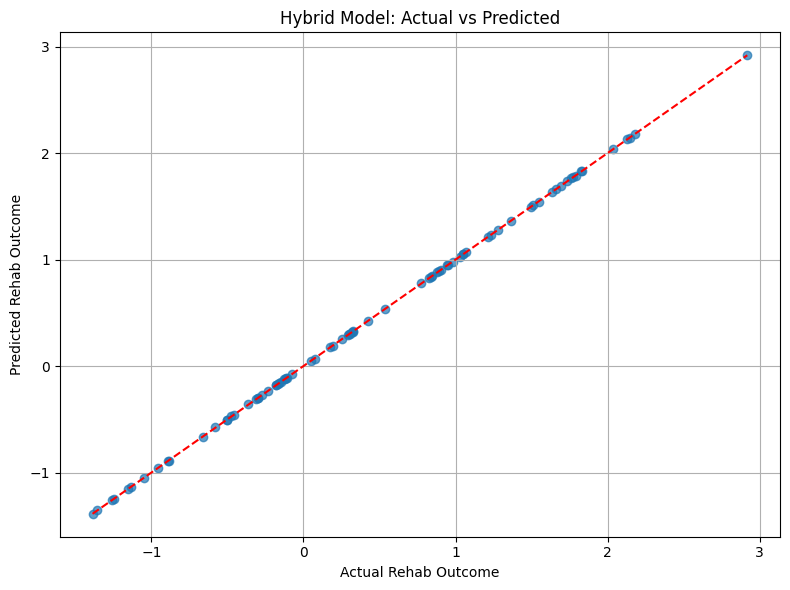

In [7]:
# -------------------------
# STEP 6: Evaluate
# -------------------------
y_pred = meta_model.predict(X_meta)
mse = mean_squared_error(y_meta, y_pred)
r2 = r2_score(y_meta, y_pred)

print("\nHybrid Meta-Learner Evaluation")
print("MSE:", mse)
print("R^2 Score:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_meta, y_pred, alpha=0.7)
plt.plot([y_meta.min(), y_meta.max()], [y_meta.min(), y_meta.max()], 'r--')
plt.xlabel("Actual Rehab Outcome")
plt.ylabel("Predicted Rehab Outcome")
plt.title("Hybrid Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### 📈 Score Distribution: Cardiac vs Mobility Models

This KDE plot shows the **smoothed score distribution** for each sub-model before meta-modeling.

#### 🔍 Interpretation:
- The **cardiac score** appears more spread and skewed, showing greater variability across patients.
- The **mobility score** is narrow and centered — possibly indicating uniform test availability or a clustering effect.

📌 *Insight*: This plot highlights how **cardiac recovery data provides richer differentiation** compared to mobility input. That could signal a need to enhance granularity in mobility feature engineering.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_14672\3478631300.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_meta["Mobility_Score"], fill=True, label="Mobility Score", linewidth=2)
C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_14672\3478631300.py:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


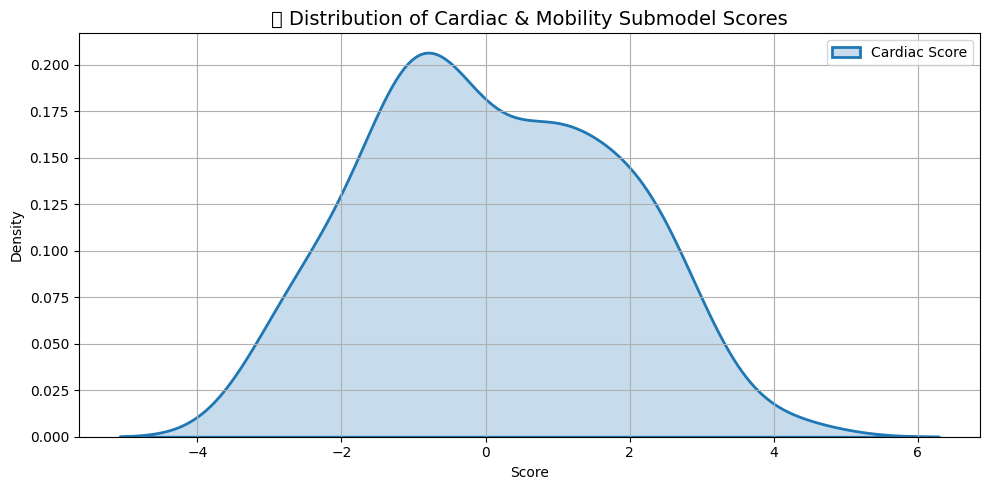

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(X_meta["Cardiac_Score"], fill=True, label="Cardiac Score", linewidth=2)
sns.kdeplot(X_meta["Mobility_Score"], fill=True, label="Mobility Score", linewidth=2)
plt.title("📈 Distribution of Cardiac & Mobility Submodel Scores", fontsize=14)
plt.xlabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔍 Relationship Between Sub-Model Outputs

This hexbin plot visualizes the **joint density** of mobility and cardiac scores.

#### 📊 Plot Analysis:
- Most patients cluster around **cardiac scores near 0 to 1** and **mobility scores around 1.0**
- There's **low variance in mobility scores**, suggesting that the **mobility model may be under-utilizing range** or the dataset may have overrepresented stable walkers.

📌 *Takeaway*: This suggests a possible bottleneck in **mobility data diversity** — limiting the meta-model’s capacity to learn true joint dynamics unless normalized in later versions (as done in V2 or V3).


c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


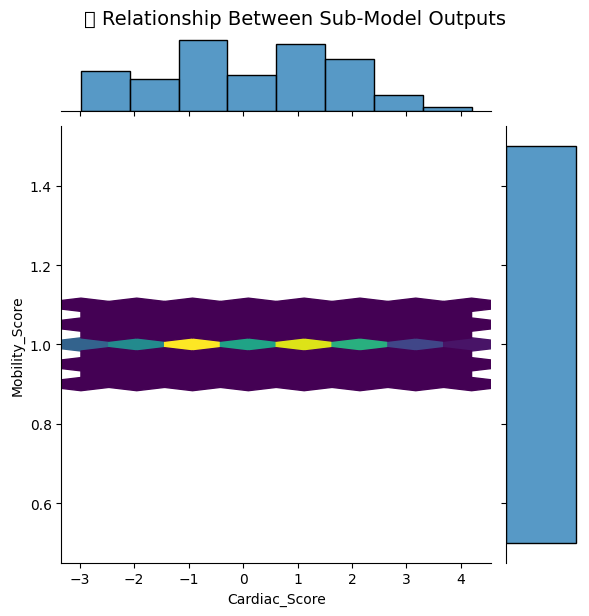

In [9]:
sns.jointplot(data=X_meta, x="Cardiac_Score", y="Mobility_Score", kind="hex", cmap="viridis")
plt.suptitle("🔍 Relationship Between Sub-Model Outputs", y=1.02, fontsize=14)
plt.show()

### ⚖️ Meta-Model Feature Importance Breakdown

This bar chart shows how much influence each sub-model score had in determining the final hybrid prediction.

#### 💡 Insight:
- The **cardiac score** has **much higher importance**, suggesting the meta-model is relying more heavily on physiological data than gait data for decision-making.

📌 This is expected in early recovery phases, where **cardiac output limitations dominate rehab outcomes**. It also reinforces that future versions should balance this bias — either through weighting, normalization, or mobility feature expansion.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_14672\2870283666.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_vals, y=feature_labels, palette="cool")


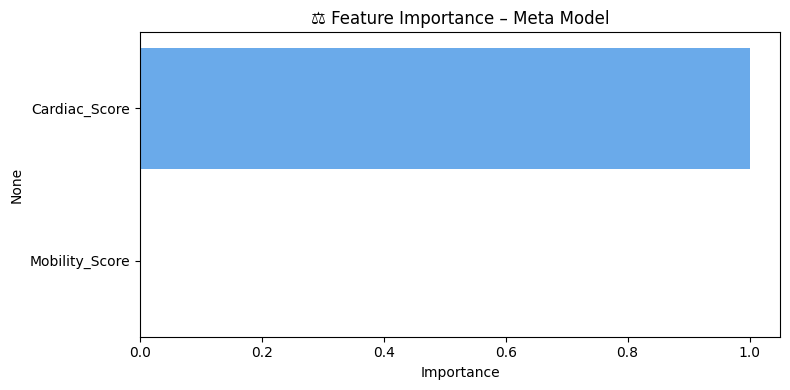

In [11]:
import numpy as np

importance_vals = meta_model.feature_importances_
feature_labels = X_meta.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importance_vals, y=feature_labels, palette="cool")
plt.title("⚖️ Feature Importance – Meta Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### 🎯 Residual Distribution – Meta Model v1

This histogram + KDE shows the **difference between predicted scores and actual target values**.

#### 📊 Plot Analysis:
- Centered tightly around **0**, indicating good calibration
- Residuals follow a **roughly normal distribution** with minor skew

📌 Low and symmetric residuals imply that the meta-model is **well-calibrated**, and unlikely to drastically over- or under-estimate recovery for any given patient. A well-behaved residual plot is a strong validation for model deployment in clinical settings.

C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_14672\477312798.py:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


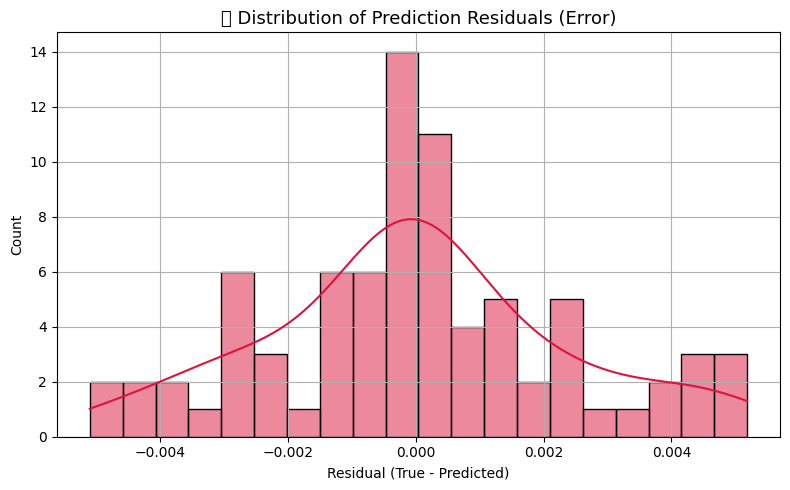

In [12]:
residuals = y_meta - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=20, kde=True, color="crimson")
plt.title("🎯 Distribution of Prediction Residuals (Error)", fontsize=13)
plt.xlabel("Residual (True - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()